In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import abc
import einx
import torch
import torch.nn as nn
import torch.distributions as D
import torchvision
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Module
from einops import rearrange, repeat
from dataclasses import dataclass, field
from typing import Tuple, cast
from matplotlib.axes import Axes

In [11]:
from flow.distrib import Circles, Checkers, Sampleable

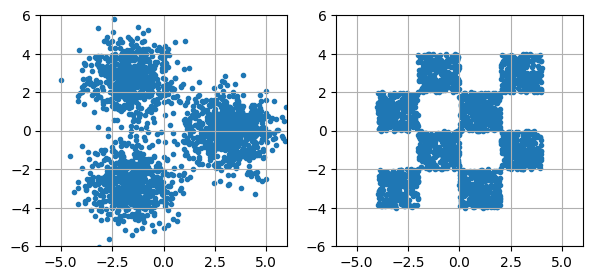

In [35]:
n_samples = (2000,)

p_init = Circles(n_modes=3)
p_data = Checkers(n_patches=2, patch_size=2, patch_fill=False)

x = p_init.sample(n_samples)
z = p_data.sample(n_samples)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

axes[0].scatter(x[:, 0], x[:, 1], marker='.')
axes[0].set_xlim(-6, 6)
axes[0].set_ylim(-6, 6)
axes[0].grid(True)

axes[1].scatter(z[:, 0], z[:, 1], marker='.')
axes[1].set_xlim(-6, 6)
axes[1].set_ylim(-6, 6)
axes[1].grid(True)

In [36]:
from torch import Tensor


class ProbabilityPath:
    @abc.abstractmethod
    def sample_conditional(self, z: Tensor, t: Tensor) -> Tensor:
        raise NotImplementedError()

    @abc.abstractmethod
    def sample_marginal(self, t: Tensor) -> Tensor:
        raise NotImplementedError()


@dataclass(kw_only=True)
class GaussianProbabilityPath(ProbabilityPath):
    p_init: Sampleable
    p_data: Sampleable

    def alpha(self, t: Tensor) -> Tensor:
        return rearrange(t, "n -> n 1")

    def beta(self, t: Tensor) -> Tensor:
        return rearrange(1 - t, "n -> n 1")

    def sample_conditional(self, z: Tensor, t: Tensor) -> Tensor:
        n_samples = t.size()

        beta_t = self.beta(t)
        alpha_t = self.alpha(t)

        x_init = self.p_init.sample(n_samples)
        x_t = alpha_t * z + beta_t * x_init

        return x_t

    def sample_marginal(self, t: Tensor) -> Tensor:
        n_samples = t.size()

        beta_t = self.beta(t)
        alpha_t = self.alpha(t)

        x_init = self.p_init.sample(n_samples)
        x_data = self.p_data.sample(n_samples)
        x_t = alpha_t * x_data + beta_t * x_init

        return x_t

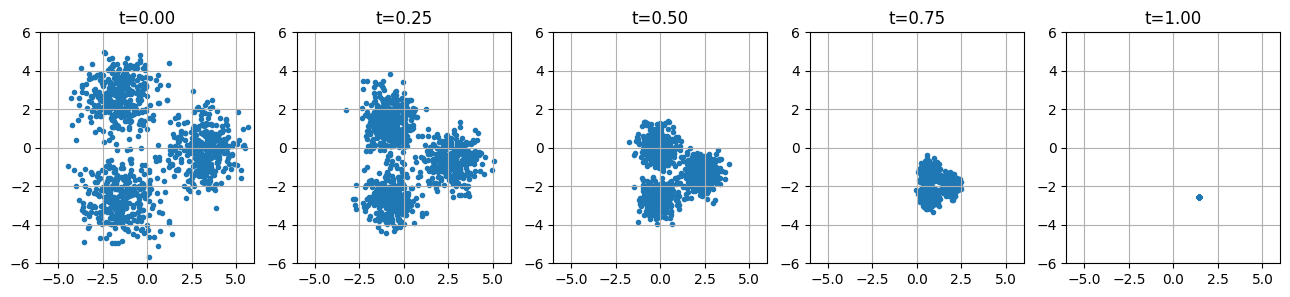

In [37]:
path_gauss = GaussianProbabilityPath(p_init=p_init, p_data=p_data)
n_samples = 1000
n_steps   = 5

t = torch.linspace(0, 1, steps=n_steps)
t = cast(Tensor, einx.rearrange('t -> (t n)', t, n=n_samples))
z = p_data.sample((1,))
pts = path_gauss.sample_conditional(z, t)
pts = rearrange(pts, '(t n) d -> t n d', n=n_samples)

fig, axes = plt.subplots(nrows=1, ncols=n_steps, figsize=(16, 3))
for t_step, axis in enumerate(axes):
    axis: Axes
    axis.scatter(pts[t_step, :, 0], pts[t_step, :, 1], marker='.')
    axis.set_title(f't={t[t_step * n_samples]:.2f}')
    axis.set_xlim(-6, 6)
    axis.set_ylim(-6, 6)
    axis.grid(True)

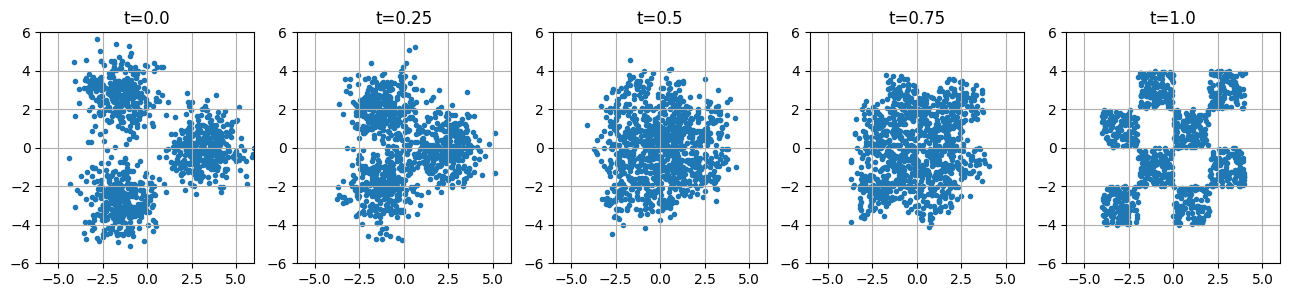

In [38]:
path_gauss = GaussianProbabilityPath(p_init=p_init, p_data=p_data)
n_samples = 1000
n_steps   = 5

t = torch.linspace(0, 1, steps=n_steps)
t = cast(Tensor, einx.rearrange('t -> (t n)', t, n=n_samples))
pts = path_gauss.sample_marginal(t)
pts = rearrange(pts, '(t n) d -> t n d', n=n_samples)

fig, axes = plt.subplots(nrows=1, ncols=n_steps, figsize=(16, 3))
for t_step, axis in enumerate(axes):
    axis: Axes
    axis.scatter(pts[t_step, :, 0], pts[t_step, :, 1], marker='.')
    axis.set_title(f't={t[t_step * n_samples]}')
    axis.set_xlim(-6, 6)
    axis.set_ylim(-6, 6)
    axis.grid(True)